<a href="https://colab.research.google.com/github/maytlim/doh_data/blob/main/labresults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
show_past_days = 5

In [72]:
import requests
import re
import pandas as pd
import datetime
import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [73]:
try:
  import pdfx
except ModuleNotFoundError:
  !pip -q install pdfx
  import pdfx

In [74]:
#Code from https://gist.github.com/korakot/51a917e1f53891d53be223439b0f75c1
from google.colab import auth
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  #gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

'''list all ids and filenames of files directly under folder folder_id'''
def folder_list_named(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [[f['id'], f['name']] for f in res['files']]

'''download specific file from a gdrive folder to current directory'''
def folder_download_specific(folder_id, search_term):
  for fid, fname in folder_list_named(folder_id):
    found = re.search(search_term, fname)
    if found:
      !gdown -q --id $fid

In [75]:
def folder_list_test(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  for f in res['files']:
    print(f)
  return [f['id'] for f in res['files']]

In [76]:
ddrop_readme = requests.get('http://bit.ly/DataDropPH').url
ddrop_readme = ddrop_readme.split('/')[-1].split('?')[0]
#print(ddrop_readme)
!rm *.pdf #remove existing pdf file before downloading 
folder_download(ddrop_readme)

In [77]:
readme_pdf = !ls *.pdf
readme_pdf = readme_pdf[0][1:-1]
readme_pdf
pdfx_tmp = pdfx.PDFx(readme_pdf)
ddlinks = pdfx_tmp.get_references_as_dict()

In [78]:
month_day = readme_pdf.split('_')
month = int(month_day[0][-2:])
day = int(month_day[1][:2])
month, day
year = 2022
print('DOH DataDrop Release:', year, month, day)

DOH DataDrop Release: 2022 1 6


In [79]:
search_term = 'Testing Aggregates'
downloaded = False
for ddlink in ddlinks['url']:
  if downloaded == False:
    if ddlink[:15] == 'https://bit.ly/' and ddlink[-3:] != 'ive':
      datadrop = requests.get(ddlink).url
      datadrop = datadrop.split('/')[-1].split('?')[0]
      #folder_download(datadrop)
      folder_download_specific(datadrop, search_term)
      print(search_term, '... downloaded')
      downloaded = True
  else:
    continue

Testing Aggregates ... downloaded


In [80]:
data_date = datetime.datetime(year, month, day)
#data_dir ='DOH COVID Data Drop_'  + data_date.strftime('%Y%m%d') + '/'

In [81]:
# testing aggregates - reporting labs
labs_filename = 'DOH COVID Data Drop_ ' + data_date.strftime('%Y%m%d') + ' - 07 Testing Aggregates.csv'
print('testing labs report:', labs_filename)

testing labs report: DOH COVID Data Drop_ 20220106 - 07 Testing Aggregates.csv


In [82]:
df_labs = pd.read_csv(labs_filename)
df_labs.keys()
date_labels = ['report_date']
for label in date_labels:
  df_labs[label] = pd.to_datetime(df_labs[label])

In [83]:
df_labs['daily_positivity'] = df_labs['daily_output_positive_individuals']/df_labs['daily_output_unique_individuals']

In [84]:
#df_labs.keys()

In [85]:
def show_hospital_details(df, hosp_name, by='daily_output_positive_individuals', min_threshold=15, show_num=5):
  filter = (df[by] > min_threshold) & (df_labs['facility_name'] == hosp_name)
  show_columns = ['report_date','daily_output_unique_individuals',
                  'daily_output_positive_individuals', 'daily_positivity','facility_name']
  return df[filter][show_columns].tail(show_num) 

In [86]:
def show_labs_list(df, by='daily_positivity', report_date='2021-12-27', cutoff_positivity=0.08, cutoff_count=100):
  filter = (df[by] > cutoff_positivity) & \
    (df['report_date'] == report_date) & \
    (df['daily_output_unique_individuals'] > cutoff_count)
  show_columns = ['report_date', 'daily_output_unique_individuals', 
                  'daily_output_positive_individuals', 'daily_positivity', 'facility_name']
  return df[filter][show_columns]

In [87]:
for t in range(1, show_past_days):
  show_date = data_date - datetime.timedelta(days=t)
  rpt_date = show_date.strftime('%Y-%m-%d')
  df = show_labs_list(df_labs, by='daily_positivity', report_date=rpt_date, 
               cutoff_positivity=0.08, cutoff_count=100)
  df.sort_values(by='daily_output_positive_individuals', inplace=True, ascending=False)
  with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 2,
                       'display.max_colwidth', -1,
                       ):
    display(df)
  df_all = df_labs[df_labs['report_date']==rpt_date]
  stats = df_all.sum()
  print(rpt_date, stats['daily_output_positive_individuals'], stats['daily_output_unique_individuals'])

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
33092,2022-01-05,3414.0,1208.0,0.35,Detoxicare Molecular Diagnostics Laboratory
83532,2022-01-05,2208.0,1178.0,0.53,Philippine Red Cross - Port Area
85567,2022-01-05,2125.0,1105.0,0.52,Philippine Red Cross Logistics & Multipurpose Center
109165,2022-01-05,2663.0,924.0,0.35,The Lord's Grace Medical and Industrial Clinic
23906,2022-01-05,1191.0,637.0,0.53,Chinese General Hospital
48165,2022-01-05,1175.0,613.0,0.52,JT Cenica Medical Health System
69960,2022-01-05,990.0,586.0,0.59,"Olayn Medical Laboratory, Inc."
45269,2022-01-05,797.0,492.0,0.62,Hi-Precision Diagnostics (QC)
9892,2022-01-05,746.0,480.0,0.64,"Be Safe MD, Inc."
61188,2022-01-05,751.0,435.0,0.58,"Marilao Medical and Diagnostic Clinc, Inc."


2022-01-05 22913.0 59719.0


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
83531,2022-01-04,2991.0,1854.0,0.62,Philippine Red Cross - Port Area
33091,2022-01-04,3381.0,1077.0,0.32,Detoxicare Molecular Diagnostics Laboratory
67263,2022-01-04,2366.0,997.0,0.42,New World Diagnostic Premium Medical Branch
109164,2022-01-04,2836.0,940.0,0.33,The Lord's Grace Medical and Industrial Clinic
9891,2022-01-04,1470.0,772.0,0.53,"Be Safe MD, Inc."
85566,2022-01-04,1750.0,716.0,0.41,Philippine Red Cross Logistics & Multipurpose Center
38319,2022-01-04,2225.0,639.0,0.29,El Roi Molecular Diagnostic Laboratory
886,2022-01-04,1278.0,580.0,0.45,AL Molecular Diagnostic Laboratory
48164,2022-01-04,1023.0,476.0,0.47,JT Cenica Medical Health System
60681,2022-01-04,1136.0,461.0,0.41,"Marilao Medical and Diagnosc Clinic, Inc. - Pasay City"


2022-01-04 24026.0 63804.0


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
33090,2022-01-03,3024.0,872.0,0.29,Detoxicare Molecular Diagnostics Laboratory
109163,2022-01-03,2118.0,855.0,0.40,The Lord's Grace Medical and Industrial Clinic
78439,2022-01-03,2702.0,788.0,0.29,Philippine Airport Diagnostic Laboratory
9890,2022-01-03,1331.0,745.0,0.56,"Be Safe MD, Inc."
885,2022-01-03,1126.0,470.0,0.42,AL Molecular Diagnostic Laboratory
23904,2022-01-03,667.0,341.0,0.51,Chinese General Hospital
38318,2022-01-03,1420.0,340.0,0.24,El Roi Molecular Diagnostic Laboratory
49804,2022-01-03,589.0,322.0,0.55,Kairos Diagnostics Laboratory
38755,2022-01-03,716.0,311.0,0.43,"Ermita Molecular Diagnostic Laboratory, Inc."
69958,2022-01-03,575.0,310.0,0.54,"Olayn Medical Laboratory, Inc."


2022-01-03 15216.0 46823.0


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
109162,2022-01-02,1689.0,610.0,0.36,The Lord's Grace Medical and Industrial Clinic
9889,2022-01-02,1105.0,507.0,0.46,"Be Safe MD, Inc."
33089,2022-01-02,1901.0,467.0,0.25,Detoxicare Molecular Diagnostics Laboratory
78438,2022-01-02,1944.0,399.0,0.21,Philippine Airport Diagnostic Laboratory
884,2022-01-02,629.0,264.0,0.42,AL Molecular Diagnostic Laboratory
23903,2022-01-02,567.0,234.0,0.41,Chinese General Hospital
10251,2022-01-02,558.0,206.0,0.37,Best Diagnostic Corporation
60679,2022-01-02,433.0,191.0,0.44,"Marilao Medical and Diagnosc Clinic, Inc. - Pasay City"
83529,2022-01-02,414.0,178.0,0.43,Philippine Red Cross - Port Area
38317,2022-01-02,558.0,169.0,0.30,El Roi Molecular Diagnostic Laboratory


2022-01-02 7434.0 27166.0


In [88]:
show_hospital_details(df_labs, "Ospital ng Imus", 
                      by='daily_positivity', min_threshold=0.08, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
71492,2021-09-28,1363.0,124.0,0.090976,Ospital ng Imus
71493,2021-09-29,260.0,40.0,0.153846,Ospital ng Imus
71494,2021-09-30,697.0,85.0,0.121951,Ospital ng Imus
71496,2021-10-02,270.0,32.0,0.118519,Ospital ng Imus
71497,2021-10-03,211.0,24.0,0.113744,Ospital ng Imus
71552,2021-11-27,30.0,3.0,0.100000,Ospital ng Imus
71582,2021-12-27,1431.0,153.0,0.106918,Ospital ng Imus
71583,2021-12-28,1106.0,107.0,0.096745,Ospital ng Imus
71590,2022-01-04,1285.0,368.0,0.286381,Ospital ng Imus
71591,2022-01-05,1309.0,126.0,0.096257,Ospital ng Imus


In [89]:
show_hospital_details(df_labs, "Manila Doctors Hospital", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
57007,2021-09-20,412.0,54.0,0.131068,Manila Doctors Hospital
57009,2021-09-22,446.0,53.0,0.118834,Manila Doctors Hospital
57011,2021-09-24,531.0,58.0,0.109228,Manila Doctors Hospital
57012,2021-09-25,447.0,61.0,0.136465,Manila Doctors Hospital
57108,2021-12-30,199.0,61.0,0.306533,Manila Doctors Hospital
57109,2021-12-31,214.0,62.0,0.289720,Manila Doctors Hospital
57111,2022-01-02,487.0,156.0,0.320329,Manila Doctors Hospital
57112,2022-01-03,495.0,163.0,0.329293,Manila Doctors Hospital
57113,2022-01-04,640.0,273.0,0.426563,Manila Doctors Hospital
57114,2022-01-05,639.0,270.0,0.422535,Manila Doctors Hospital


In [90]:
show_hospital_details(df_labs, "Chinese General Hospital", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
23808,2021-09-29,768.0,144.0,0.187500,Chinese General Hospital
23809,2021-09-30,828.0,128.0,0.154589,Chinese General Hospital
23811,2021-10-02,818.0,147.0,0.179707,Chinese General Hospital
23814,2021-10-05,697.0,106.0,0.152080,Chinese General Hospital
23900,2021-12-30,525.0,200.0,0.380952,Chinese General Hospital
23901,2021-12-31,423.0,200.0,0.472813,Chinese General Hospital
23902,2022-01-01,653.0,227.0,0.347626,Chinese General Hospital
23903,2022-01-02,567.0,234.0,0.412698,Chinese General Hospital
23904,2022-01-03,667.0,341.0,0.511244,Chinese General Hospital
23906,2022-01-05,1191.0,637.0,0.534845,Chinese General Hospital


In [91]:
show_hospital_details(df_labs, "UP-PGH Molecular Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
114220,2021-09-30,546.0,54.0,0.098901,UP-PGH Molecular Laboratory
114224,2021-10-04,430.0,53.0,0.123256,UP-PGH Molecular Laboratory
114227,2021-10-07,329.0,54.0,0.164134,UP-PGH Molecular Laboratory
114311,2021-12-30,385.0,59.0,0.153247,UP-PGH Molecular Laboratory
114312,2021-12-31,495.0,90.0,0.181818,UP-PGH Molecular Laboratory
114313,2022-01-01,285.0,79.0,0.277193,UP-PGH Molecular Laboratory
114314,2022-01-02,136.0,53.0,0.389706,UP-PGH Molecular Laboratory
114315,2022-01-03,277.0,116.0,0.418773,UP-PGH Molecular Laboratory
114316,2022-01-04,589.0,317.0,0.538200,UP-PGH Molecular Laboratory
114317,2022-01-05,454.0,276.0,0.607930,UP-PGH Molecular Laboratory


In [92]:
show_hospital_details(df_labs, "Philippine Children's Medical Center", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
78946,2021-09-22,583.0,70.0,0.120069,Philippine Children's Medical Center
78949,2021-09-25,856.0,70.0,0.081776,Philippine Children's Medical Center
78953,2021-09-29,287.0,56.0,0.195122,Philippine Children's Medical Center
79044,2021-12-29,1061.0,65.0,0.061263,Philippine Children's Medical Center
79046,2021-12-31,850.0,91.0,0.107059,Philippine Children's Medical Center
79047,2022-01-01,882.0,94.0,0.106576,Philippine Children's Medical Center
79048,2022-01-02,942.0,93.0,0.098726,Philippine Children's Medical Center
79049,2022-01-03,532.0,209.0,0.392857,Philippine Children's Medical Center
79050,2022-01-04,443.0,209.0,0.471783,Philippine Children's Medical Center
79051,2022-01-05,370.0,191.0,0.516216,Philippine Children's Medical Center


In [93]:
show_hospital_details(df_labs, "The Lord's Grace Medical and Industrial Clinic", 
                      by='daily_output_positive_individuals', min_threshold=300, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
109050,2021-09-12,970.0,301.0,0.310309,The Lord's Grace Medical and Industrial Clinic
109052,2021-09-14,1064.0,387.0,0.363722,The Lord's Grace Medical and Industrial Clinic
109055,2021-09-17,1105.0,417.0,0.377376,The Lord's Grace Medical and Industrial Clinic
109060,2021-09-22,1515.0,329.0,0.217162,The Lord's Grace Medical and Industrial Clinic
109160,2021-12-31,961.0,304.0,0.316337,The Lord's Grace Medical and Industrial Clinic
109161,2022-01-01,950.0,320.0,0.336842,The Lord's Grace Medical and Industrial Clinic
109162,2022-01-02,1689.0,610.0,0.361160,The Lord's Grace Medical and Industrial Clinic
109163,2022-01-03,2118.0,855.0,0.403683,The Lord's Grace Medical and Industrial Clinic
109164,2022-01-04,2836.0,940.0,0.331453,The Lord's Grace Medical and Industrial Clinic
109165,2022-01-05,2663.0,924.0,0.346977,The Lord's Grace Medical and Industrial Clinic


In [94]:
show_hospital_details(df_labs, "Best Diagnostic Corporation", 
                      by='daily_output_positive_individuals', min_threshold=30, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
10165,2021-10-08,155.0,31.0,0.200000,Best Diagnostic Corporation
10168,2021-10-11,73.0,33.0,0.452055,Best Diagnostic Corporation
10169,2021-10-12,126.0,31.0,0.246032,Best Diagnostic Corporation
10176,2021-10-19,171.0,35.0,0.204678,Best Diagnostic Corporation
10246,2021-12-28,180.0,38.0,0.211111,Best Diagnostic Corporation
10247,2021-12-29,212.0,93.0,0.438679,Best Diagnostic Corporation
10248,2021-12-30,309.0,121.0,0.391586,Best Diagnostic Corporation
10250,2022-01-01,241.0,99.0,0.410788,Best Diagnostic Corporation
10251,2022-01-02,558.0,206.0,0.369176,Best Diagnostic Corporation
10252,2022-01-03,377.0,169.0,0.448276,Best Diagnostic Corporation


In [95]:
show_hospital_details(df_labs, "Detoxicare Molecular Diagnostics Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=300, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
32997,2021-10-02,3345.0,485.0,0.144993,Detoxicare Molecular Diagnostics Laboratory
32998,2021-10-03,2827.0,383.0,0.135479,Detoxicare Molecular Diagnostics Laboratory
33000,2021-10-05,3034.0,405.0,0.133487,Detoxicare Molecular Diagnostics Laboratory
33001,2021-10-06,3077.0,336.0,0.109197,Detoxicare Molecular Diagnostics Laboratory
33087,2021-12-31,2400.0,458.0,0.190833,Detoxicare Molecular Diagnostics Laboratory
33088,2022-01-01,1973.0,366.0,0.185504,Detoxicare Molecular Diagnostics Laboratory
33089,2022-01-02,1901.0,467.0,0.245660,Detoxicare Molecular Diagnostics Laboratory
33090,2022-01-03,3024.0,872.0,0.288360,Detoxicare Molecular Diagnostics Laboratory
33091,2022-01-04,3381.0,1077.0,0.318545,Detoxicare Molecular Diagnostics Laboratory
33092,2022-01-05,3414.0,1208.0,0.353837,Detoxicare Molecular Diagnostics Laboratory


In [96]:
show_hospital_details(df_labs, "Detoxicare Molecular Diagnostics Laboratory", 
                      by='daily_positivity', min_threshold=0.15, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
32991,2021-09-26,2935.0,543.0,0.185009,Detoxicare Molecular Diagnostics Laboratory
32993,2021-09-28,2930.0,554.0,0.189078,Detoxicare Molecular Diagnostics Laboratory
32994,2021-09-29,3039.0,534.0,0.175716,Detoxicare Molecular Diagnostics Laboratory
32995,2021-09-30,3032.0,519.0,0.171174,Detoxicare Molecular Diagnostics Laboratory
33087,2021-12-31,2400.0,458.0,0.190833,Detoxicare Molecular Diagnostics Laboratory
33088,2022-01-01,1973.0,366.0,0.185504,Detoxicare Molecular Diagnostics Laboratory
33089,2022-01-02,1901.0,467.0,0.245660,Detoxicare Molecular Diagnostics Laboratory
33090,2022-01-03,3024.0,872.0,0.288360,Detoxicare Molecular Diagnostics Laboratory
33091,2022-01-04,3381.0,1077.0,0.318545,Detoxicare Molecular Diagnostics Laboratory
33092,2022-01-05,3414.0,1208.0,0.353837,Detoxicare Molecular Diagnostics Laboratory


In [97]:
show_hospital_details(df_labs, "San Lazaro Hospital (SLH)", by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
95980,2021-09-10,152.0,64.0,0.421053,San Lazaro Hospital (SLH)
95982,2021-09-12,201.0,74.0,0.368159,San Lazaro Hospital (SLH)
95986,2021-09-16,217.0,67.0,0.308756,San Lazaro Hospital (SLH)
95987,2021-09-17,166.0,65.0,0.391566,San Lazaro Hospital (SLH)
95989,2021-09-19,175.0,55.0,0.314286,San Lazaro Hospital (SLH)
96001,2021-10-01,177.0,53.0,0.299435,San Lazaro Hospital (SLH)
96092,2021-12-31,120.0,73.0,0.608333,San Lazaro Hospital (SLH)
96095,2022-01-03,215.0,116.0,0.539535,San Lazaro Hospital (SLH)
96096,2022-01-04,276.0,260.0,0.942029,San Lazaro Hospital (SLH)
96097,2022-01-05,376.0,206.0,0.547872,San Lazaro Hospital (SLH)


In [98]:
show_hospital_details(df_labs, "Sta. Ana Hospital - Closed System Molecular Laboratory (RT PCR)", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
104757,2021-09-16,640.0,114.0,0.178125,Sta. Ana Hospital - Closed System Molecular La...
104762,2021-09-21,729.0,122.0,0.167353,Sta. Ana Hospital - Closed System Molecular La...
104763,2021-09-22,459.0,109.0,0.237473,Sta. Ana Hospital - Closed System Molecular La...
104765,2021-09-24,549.0,107.0,0.194900,Sta. Ana Hospital - Closed System Molecular La...
104766,2021-09-25,544.0,109.0,0.200368,Sta. Ana Hospital - Closed System Molecular La...
104862,2021-12-30,349.0,187.0,0.535817,Sta. Ana Hospital - Closed System Molecular La...
104863,2021-12-31,234.0,105.0,0.448718,Sta. Ana Hospital - Closed System Molecular La...
104866,2022-01-03,218.0,148.0,0.678899,Sta. Ana Hospital - Closed System Molecular La...
104867,2022-01-04,486.0,298.0,0.613169,Sta. Ana Hospital - Closed System Molecular La...
104868,2022-01-05,454.0,251.0,0.552863,Sta. Ana Hospital - Closed System Molecular La...


In [99]:
show_hospital_details(df_labs, "Philippine Red Cross (PRC)", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
80808,2021-10-25,1155.0,107.0,0.092641,Philippine Red Cross (PRC)
80812,2021-10-29,1385.0,141.0,0.101805,Philippine Red Cross (PRC)
80814,2021-10-31,1360.0,192.0,0.141176,Philippine Red Cross (PRC)
80820,2021-11-06,1845.0,125.0,0.067751,Philippine Red Cross (PRC)
80873,2021-12-29,789.0,106.0,0.134347,Philippine Red Cross (PRC)
80874,2021-12-30,966.0,143.0,0.148033,Philippine Red Cross (PRC)
80875,2021-12-31,384.0,117.0,0.304688,Philippine Red Cross (PRC)
80878,2022-01-03,500.0,267.0,0.534000,Philippine Red Cross (PRC)
80879,2022-01-04,580.0,302.0,0.520690,Philippine Red Cross (PRC)
80880,2022-01-05,858.0,375.0,0.437063,Philippine Red Cross (PRC)


In [100]:
show_hospital_details(df_labs, "Philippine Red Cross - Port Area", 
                      by='daily_output_positive_individuals', min_threshold=200, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
83447,2021-10-12,3590.0,327.0,0.091086,Philippine Red Cross - Port Area
83448,2021-10-13,3191.0,256.0,0.080226,Philippine Red Cross - Port Area
83461,2021-10-26,2726.0,232.0,0.085106,Philippine Red Cross - Port Area
83525,2021-12-29,1052.0,207.0,0.196768,Philippine Red Cross - Port Area
83526,2021-12-30,1307.0,409.0,0.312930,Philippine Red Cross - Port Area
83527,2021-12-31,747.0,204.0,0.273092,Philippine Red Cross - Port Area
83528,2022-01-01,423.0,241.0,0.569740,Philippine Red Cross - Port Area
83530,2022-01-03,1056.0,262.0,0.248106,Philippine Red Cross - Port Area
83531,2022-01-04,2991.0,1854.0,0.619860,Philippine Red Cross - Port Area
83532,2022-01-05,2208.0,1178.0,0.533514,Philippine Red Cross - Port Area


In [101]:
def juxtapose_spreads(df, show_dates):
  n_dates = len(show_dates)
  filter = []
  xhigh = 0
  for i, show_date in enumerate(show_dates):
    filter.append(df['report_date'] == show_date)
    xhigh = max(df[filter[i]]['daily_output_positive_individuals'].max(), xhigh)

  fig, axes = plt.subplots(ncols=n_dates, figsize=(n_dates*5 + 2, 5))

  for i in range(n_dates):
    pts = axes[i].plot(df[filter[i]]['daily_positivity']*100, 
         df[filter[i]]['daily_output_positive_individuals'],
         'ro', alpha=0.33)
    axes[i].set_xlabel('positivity rate(%)')
    axes[i].set_ylabel('positive cases')
    axes[i].set_ylim(bottom=0, top=xhigh+5)
    axes[i].set_xlim(right=100) 
    axes[i].set_title(show_dates[i] + ' : ' + str(int(df[filter[i]]['daily_output_positive_individuals'].sum())))

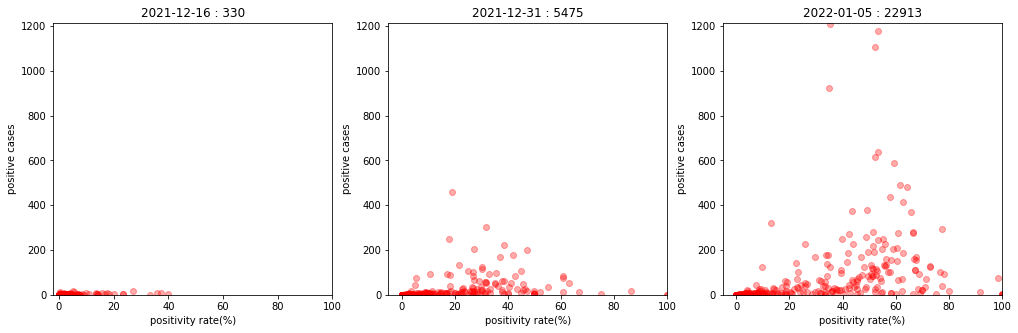

In [102]:
show_date = data_date - datetime.timedelta(days=1)
latest_date = show_date.strftime('%Y-%m-%d')
juxtapose_spreads(df_labs, ['2021-12-16', '2021-12-31', latest_date])

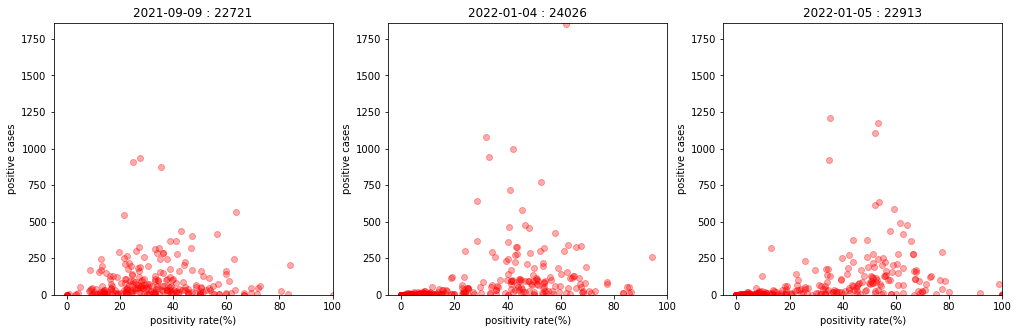

In [103]:
show_dates = []
show_dates.append(data_date - datetime.timedelta(days=1))
show_dates.append(data_date - datetime.timedelta(days=2))
latest_date = show_dates[0].strftime('%Y-%m-%d')
prev_date = show_dates[1].strftime('%Y-%m-%d')
juxtapose_spreads(df_labs, ['2021-09-09', prev_date, latest_date])

In [109]:
df_labs[(df_labs['report_date']==latest_date) & 
        (df_labs['daily_output_positive_individuals'] > 200)][['facility_name', 'report_date', 
                                                              'daily_output_unique_individuals', 
                                                              'daily_output_positive_individuals',
                                                              'daily_positivity']].sort_values(by='daily_positivity', ascending=False)

,facility_name,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity
102747,St. Luke's Medical Center - BGC (SLMC-BGC),2022-01-05,379.0,293.0,0.773087
77355,Pasig City Molecular Laboratory,2022-01-05,422.0,281.0,0.665877
39895,Fe del Mundo Medical center,2022-01-05,419.0,278.0,0.663484
65830,National Kidney and Transplant Institute,2022-01-05,561.0,369.0,0.657754
9892,"Be Safe MD, Inc.",2022-01-05,746.0,480.0,0.643432
117233,Valenzuela Hope Molecular Laboratory,2022-01-05,659.0,413.0,0.626707
45269,Hi-Precision Diagnostics (QC),2022-01-05,797.0,492.0,0.617315
114317,UP-PGH Molecular Laboratory,2022-01-05,454.0,276.0,0.607930
56292,Makati Medical Center (MMC),2022-01-05,344.0,208.0,0.604651
69960,"Olayn Medical Laboratory, Inc.",2022-01-05,990.0,586.0,0.591919
